In [1]:
%reload_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
import plotly.express as px
import random
from manofunkcijos import *

import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver # naršyklės kontroleris
from selenium.webdriver.chrome.options import Options #Naršyklės
# pip install beautifulsoup4 selenium
import time

In [54]:
# Informacijos gavimas iš autoplius.lt
# Užduotys
# Naudodamiesi selenium, beautifulsoup bibliotekomis bei pasirinkta naršykle, nuskaitykite
# autoplius.lt skelbimų informaciją.
# Nuskaityta informacija turi būti saugoma jūsų susikurtoje SQLite duomenų bazėje (DB).

# Jūsų skriptas turi surinkti ir į DB surašyti visą reikiamą infromaciją, kuri būtų reikalinga toli-
# mesnei analizei. Vizualizacijoms/analizei duomenis toliau turite imti iš savo užpildytos SQLi-
# te DB.

# Klausimai:

# Įvertinkite automobilių kainos priklausomybes nuo ridos, amžiaus, variklio galios, kėbulo ti-
# po, pavarų dėžės tipo. Įvertinkite, ar kainos dydžiui turi įtaką pardavėjo miestas/rajonas? Ko-
# kios šalys vyrauja kaip pirmos registracijos šalis? Ar dėl to yra kokia nors įtaka kainoms?

# Kiek skelbimų nurodo galiojančią TA? Ar TA turėjimas ir TA galiojimo trukmė turi įtaką
# kainų lygiui?
# Kokie 10 gamintojų buvo populiariausi? Pateikite šių gamintojų automobiliams kainos

# kitimo trendus nuo ridos, amžiaus, variklio galios. Kurio gamintojo automobiliai pigo spar-
# čiausiai, o kuris gamintojas(-ai) ilgiausiai išlaikydavo savo vertę (kaina nuo ridos/amžiaus)?

# Kuris gamintojas/gamintojai turėjo didžiausią kainų išsibarstymą? Suraskite 10 retesnių au-
# tomobilių gamintojų (5 < x < 15 vnt).

# Pateikite 10 populiariausių gamintojų variklio galių (kW), ridų, amžiaus, rinkoje esančių
# modelių kiekio vienetais pasiskirstymą (vidurkiai, medianos, kvartilės).

# Ar yra priklausomybė tarp kainų ir elektromobilių akumuliatoriaus talpos (kWh), el. varik-
# lio galios (kW)? Kaip sparčiai pigo elektromobiliai? Ar buvo gamintojų, kurių elektromobiliai

# ilgai išlaikydavo vertę (pigo lėčiausiai)?
# Ar elektromobilių kainos nuo ridos, amžiaus priklauso (kito) labiau, nei VDV automobilių?
# Kiek skelbimuose buvo automobilių su defektais, be defektų? Kokie gamintojai vyravo
# skelbimuose, nurodančiuose defektus?
# Visiems klausimams parinkite ir pateikite vizualizacijas, leidžiančias atsakyti į klausimus.
# Vizualizacijas pateikti streamlit aplinkoje.

In [171]:

db_path = 'web_scrap.db'
query = 'SELECT * FROM autopliuslt2;'  # SQL užklausa, kurią norite vykdyti

df = query_to_dataframe(db_path, query)


In [172]:
dft = df

In [173]:
dft['Kaina'] = dft['Kaina'].apply(lambda x: float(x))
dft['Rida'] = dft['Rida'].apply(lambda x: x[:-3].replace(' ','') if x != None else x)

In [174]:
dft['Rida'] = dft['Rida'].apply(lambda x: float(x) if x!= None and x!='' else x )

In [175]:
dft['Rida_group'] = dft['Rida'].apply(lambda x: np.ceil(x/50000)*50000)

In [176]:
dft['Amžius'] = dft['Pirma registracija'].apply(lambda x: (np.ceil((2024-int(x[:4]))/5))*5 if x!= None else x)

In [222]:
dft['Amžius2'] = dft['Pirma registracija'].apply(lambda x: int(2024-int(x[:4])) if x!= None else x)

In [177]:
x = '39 AG (29kW)'
c = int(x.split('(')[1].replace('kW)',''))
print(c)

29


In [178]:
def kw(x):
    if x != None:
        if 'kW' in x:
            return int((np.ceil(int(x.split('(')[1].replace('kW)',''))/20))*20)
        else:
            return None
    else:
        return None

In [179]:
dft['Galingumas'] = dft['Variklis'].apply(kw)

In [217]:
def kw2(x):
    if x != None:
        if 'kW' in x:
            return int(x.split('(')[1].replace('kW)',''))
        else:
            return None
    else:
        return None

In [218]:
dft['Galingumas2'] = dft['Variklis'].apply(kw2)

In [180]:
dft['Tik Miestas'] = dft['Miestas'].apply(lambda x: x.split(',')[0] if x!=None else None)

In [181]:
dft.head()

,id,Markė,Modelis,Kaina,Miestas,Pirma registracija,Kuro tipas,Kėbulo tipas,Durų skaičius,Pavarų dėžė,...,Defektai,Pagaminimo data,Vairo padėtis,Registracijos data,Ilgis,Aukštis,Rida_group,Amžius,Galingumas,Tik Miestas
0,1,-Kita-,-kita-,1750.0,"Utena, Lietuva",2008-09,Dyzelinas,Krovininis mikroautobusas,Kita,Mechaninė,...,None,None,None,None,None,None,NaN,20.0,NaN,Utena
1,2,-Kita-,-kita-,3900.0,"Jurbarkas, Lietuva",2011,Elektra,Sedanas,2/3,None,...,None,None,None,None,None,None,50000.0,15.0,NaN,Jurbarkas
2,3,-Kita-,-kita-,6800.0,"Kėdainiai, Lietuva",2020-02,Elektra,Hečbekas,2/3,None,...,None,None,None,None,None,None,50000.0,5.0,40.0,Kėdainiai
3,4,-Kita-,-kita-,60500.0,"Vilnius, Lietuva",2024,Elektra,Krovininis mikroautobusas,4/5,None,...,None,None,None,None,None,None,NaN,0.0,80.0,Vilnius
4,5,Abarth,124 Spider,18900.0,"Kaunas, Lietuva",2017,Benzinas,Kabrioletas,2/3,Mechaninė,...,None,None,None,None,None,None,100000.0,10.0,140.0,Kaunas


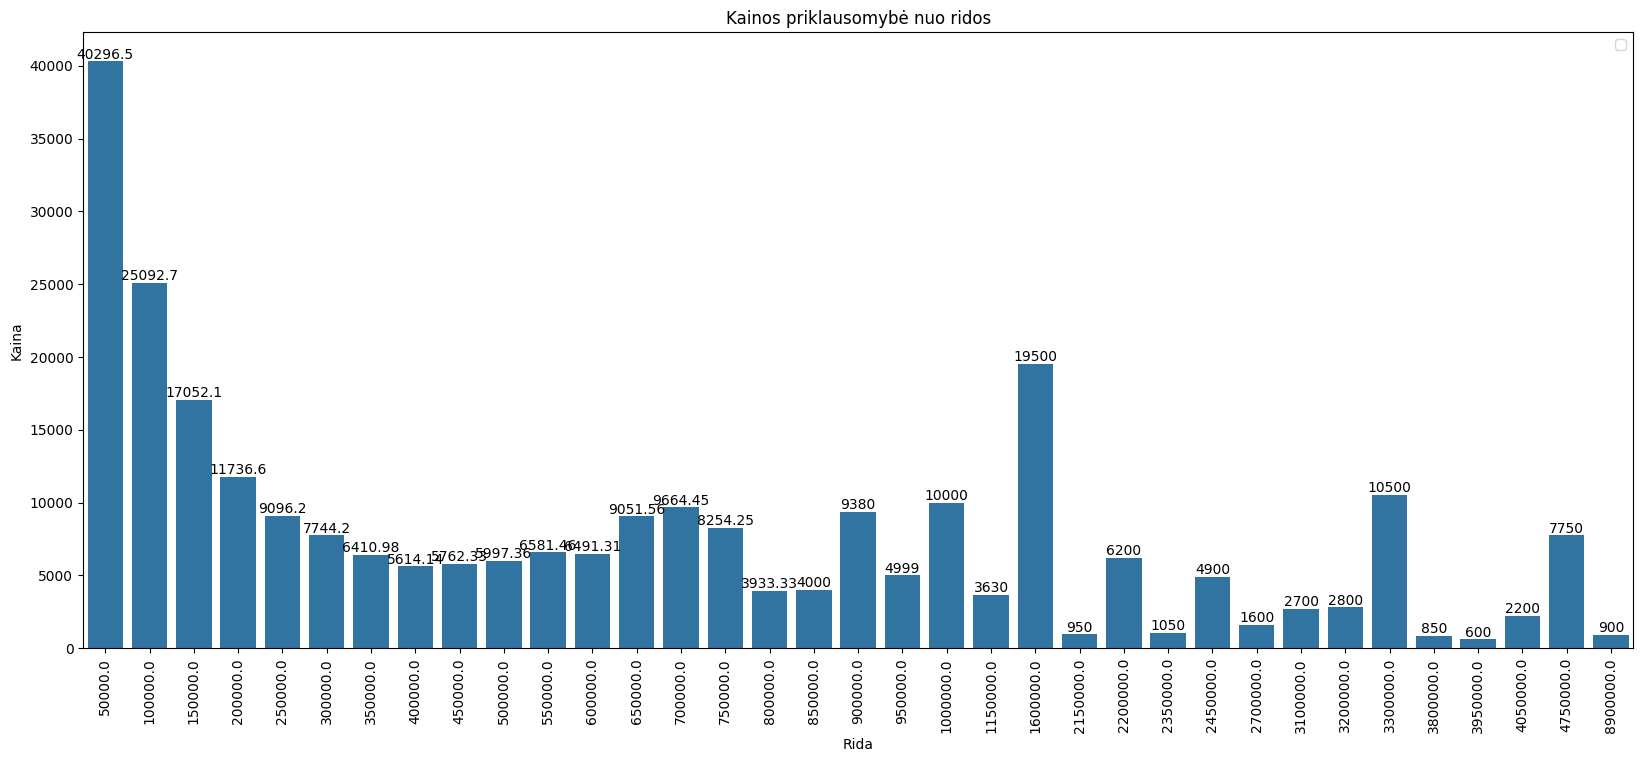

In [182]:
fig, axes = plt.subplots(figsize=(20,8))
dfx = dft.groupby(['Rida_group'])['Kaina'].mean().reset_index()
axes.set_title(f'Kainos priklausomybė nuo ridos')
ax =sns.barplot(data=dfx,x = 'Rida_group', y='Kaina', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Rida',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

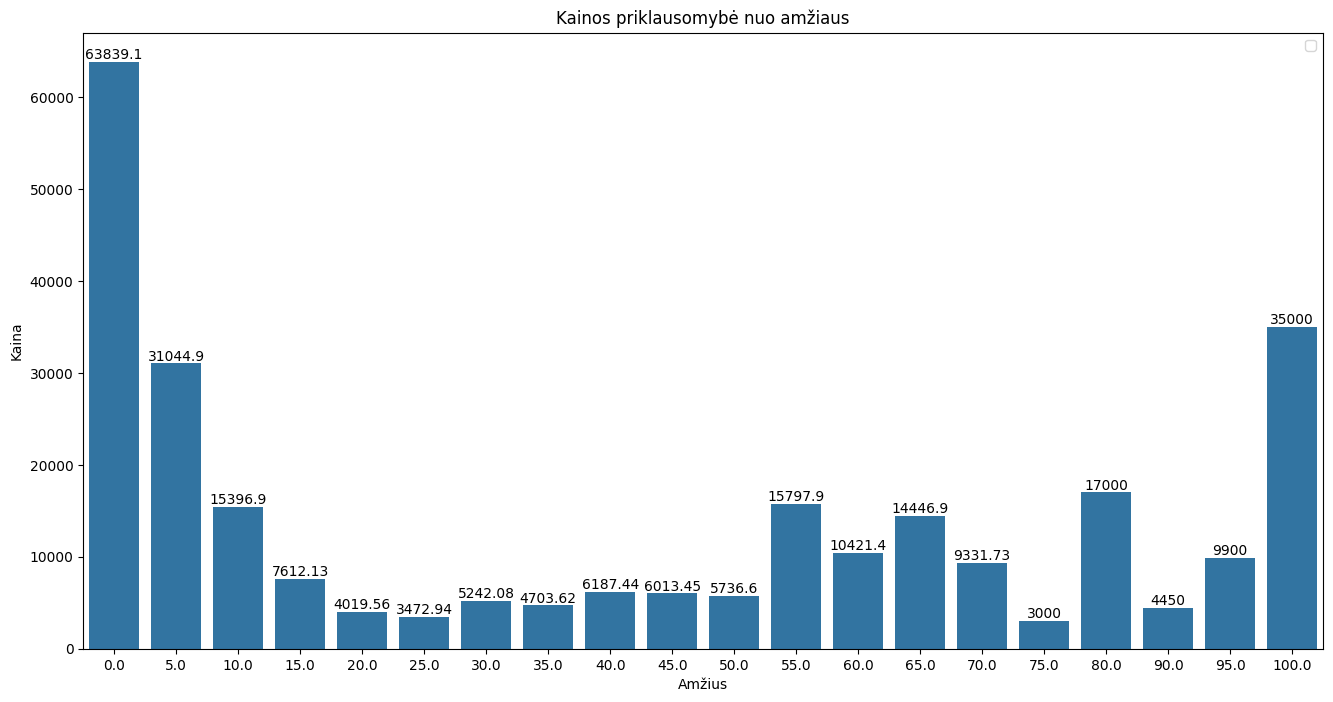

In [183]:
fig, axes = plt.subplots(figsize=(16,8))
dfx = dft.groupby(['Amžius'])['Kaina'].mean().reset_index()
axes.set_title(f'Kainos priklausomybė nuo amžiaus')
ax =sns.barplot(data=dfx,x = 'Amžius', y='Kaina', ax=axes)
axes.set(xlabel='Amžius',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

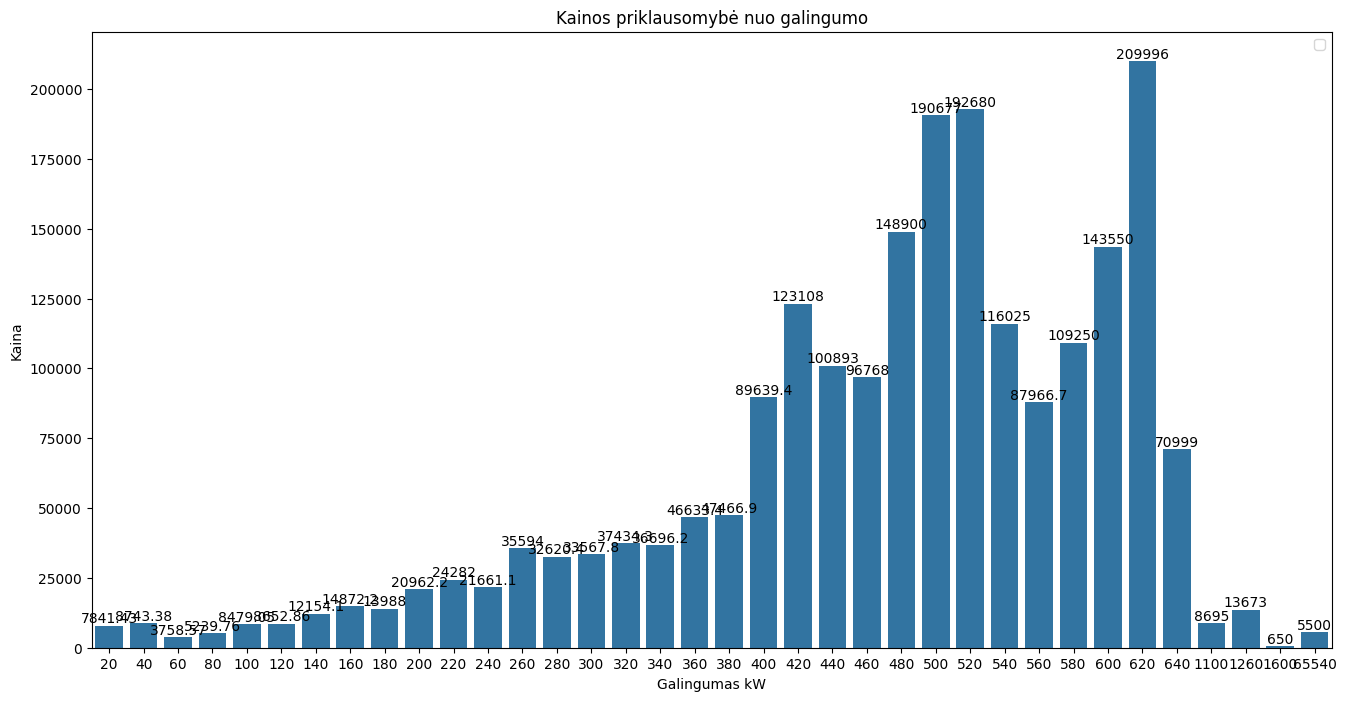

In [184]:
fig, axes = plt.subplots(figsize=(16,8))
dfx = dft[dft['Galingumas'] != np.nan].groupby(['Galingumas'])['Kaina'].mean().reset_index()
dfx['Galingumas'] = dfx['Galingumas'].apply(lambda x: int(x))
axes.set_title(f'Kainos priklausomybė nuo galingumo')
ax =sns.barplot(data=dfx,x = 'Galingumas', y='Kaina', )
axes.set(xlabel='Galingumas kW',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

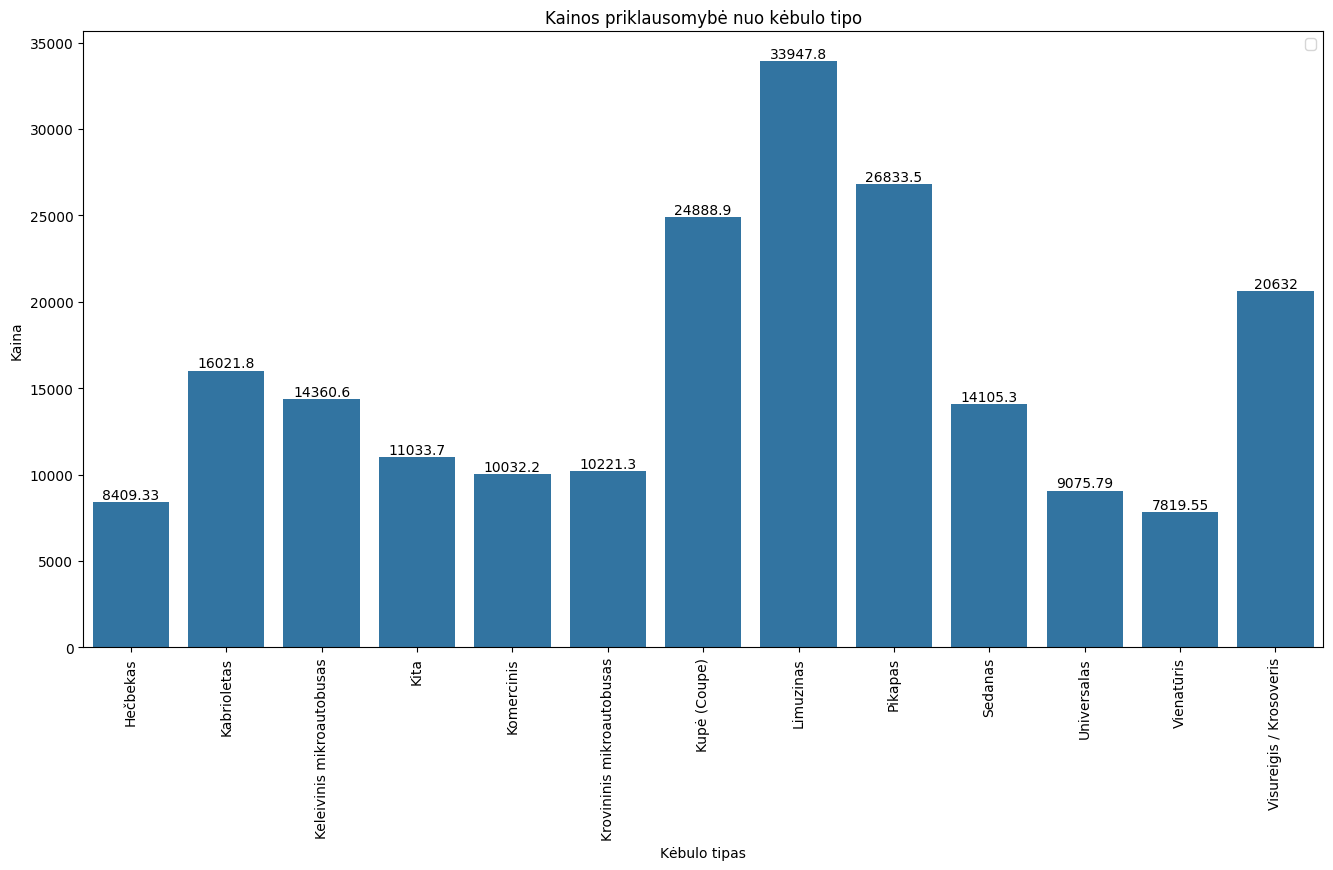

In [185]:

fig, axes = plt.subplots(figsize=(16,8))
dfx = dft[dft['Kėbulo tipas'] != np.nan].groupby(['Kėbulo tipas'])['Kaina'].mean().reset_index()
axes.set_title(f'Kainos priklausomybė nuo kėbulo tipo')
ax =sns.barplot(data=dfx,x = 'Kėbulo tipas', y='Kaina', )
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Kėbulo tipas',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

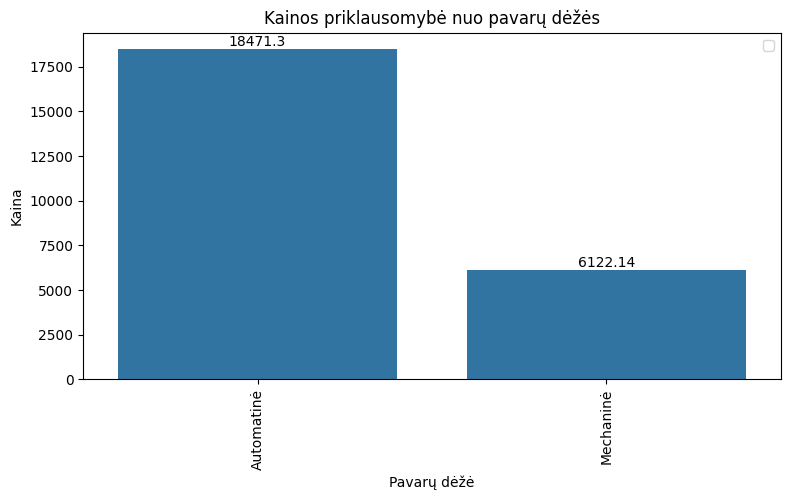

In [186]:
fig, axes = plt.subplots(figsize=(9,4.5))
dfx = dft[dft['Pavarų dėžė'] != np.nan].groupby(['Pavarų dėžė'])['Kaina'].mean().reset_index()
axes.set_title(f'Kainos priklausomybė nuo pavarų dėžės')
ax =sns.barplot(data=dfx,x = 'Pavarų dėžė', y='Kaina', )
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Pavarų dėžė',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

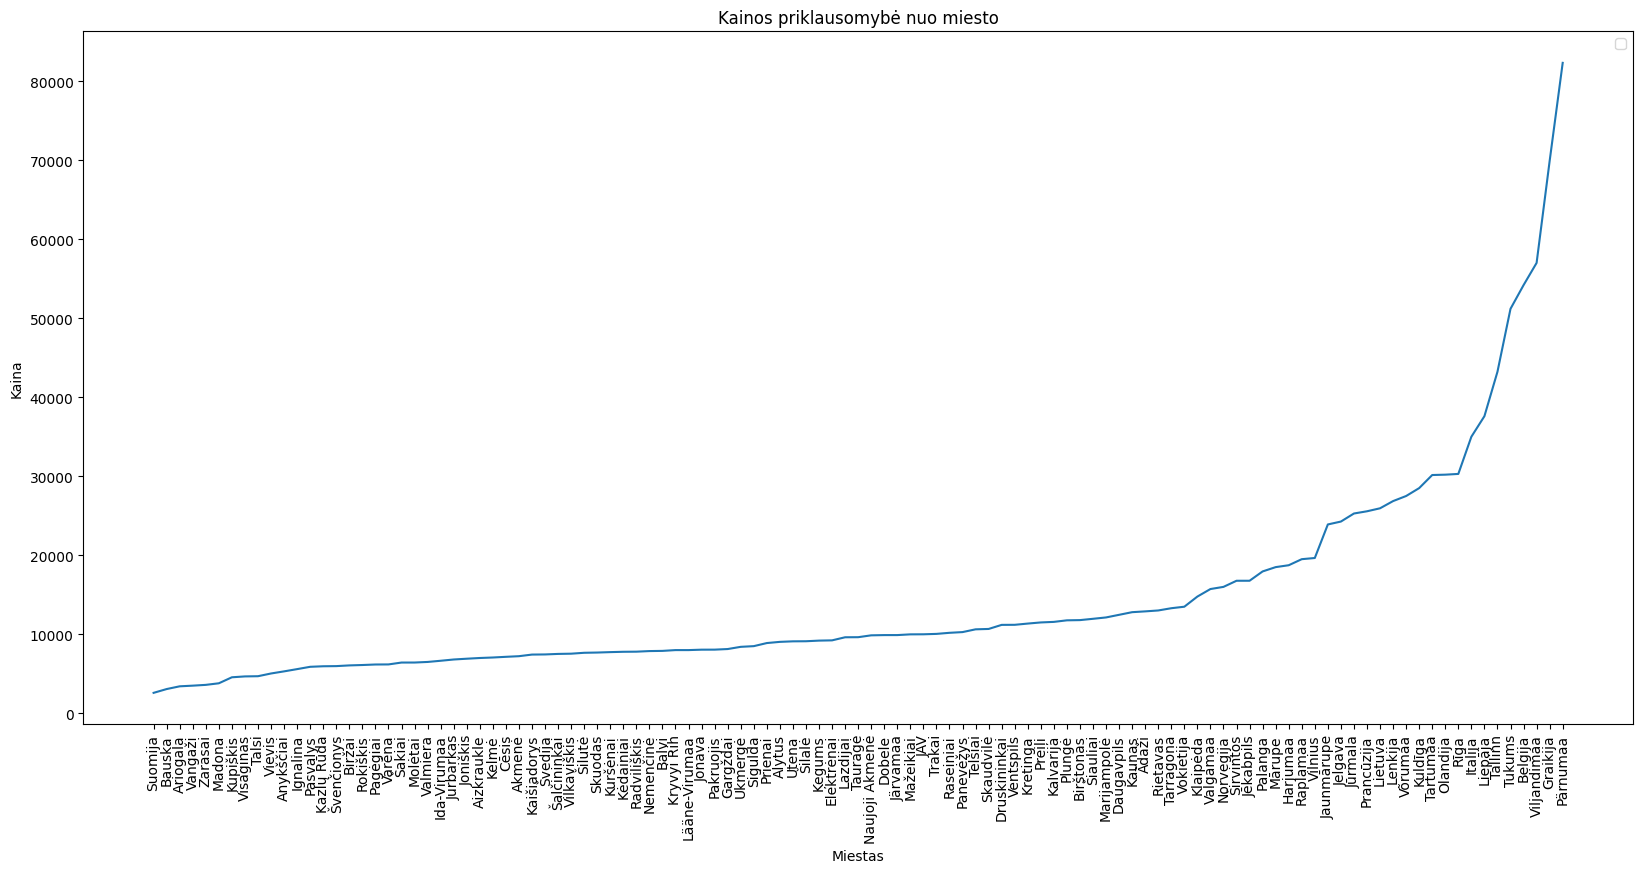

In [187]:
fig, axes = plt.subplots(figsize=(20,9))
dfx = dft[dft['Tik Miestas'] != np.nan].groupby(['Tik Miestas'])['Kaina'].mean().reset_index().sort_values(by= 'Kaina',ascending=True)
axes.set_title(f'Kainos priklausomybė nuo miesto')
ax =sns.lineplot(data=dfx,x = 'Tik Miestas', y='Kaina', )
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Miestas',ylabel='Kaina')
# for container in ax.containers:
#     ax.bar_label(container)
axes.legend()
plt.show()

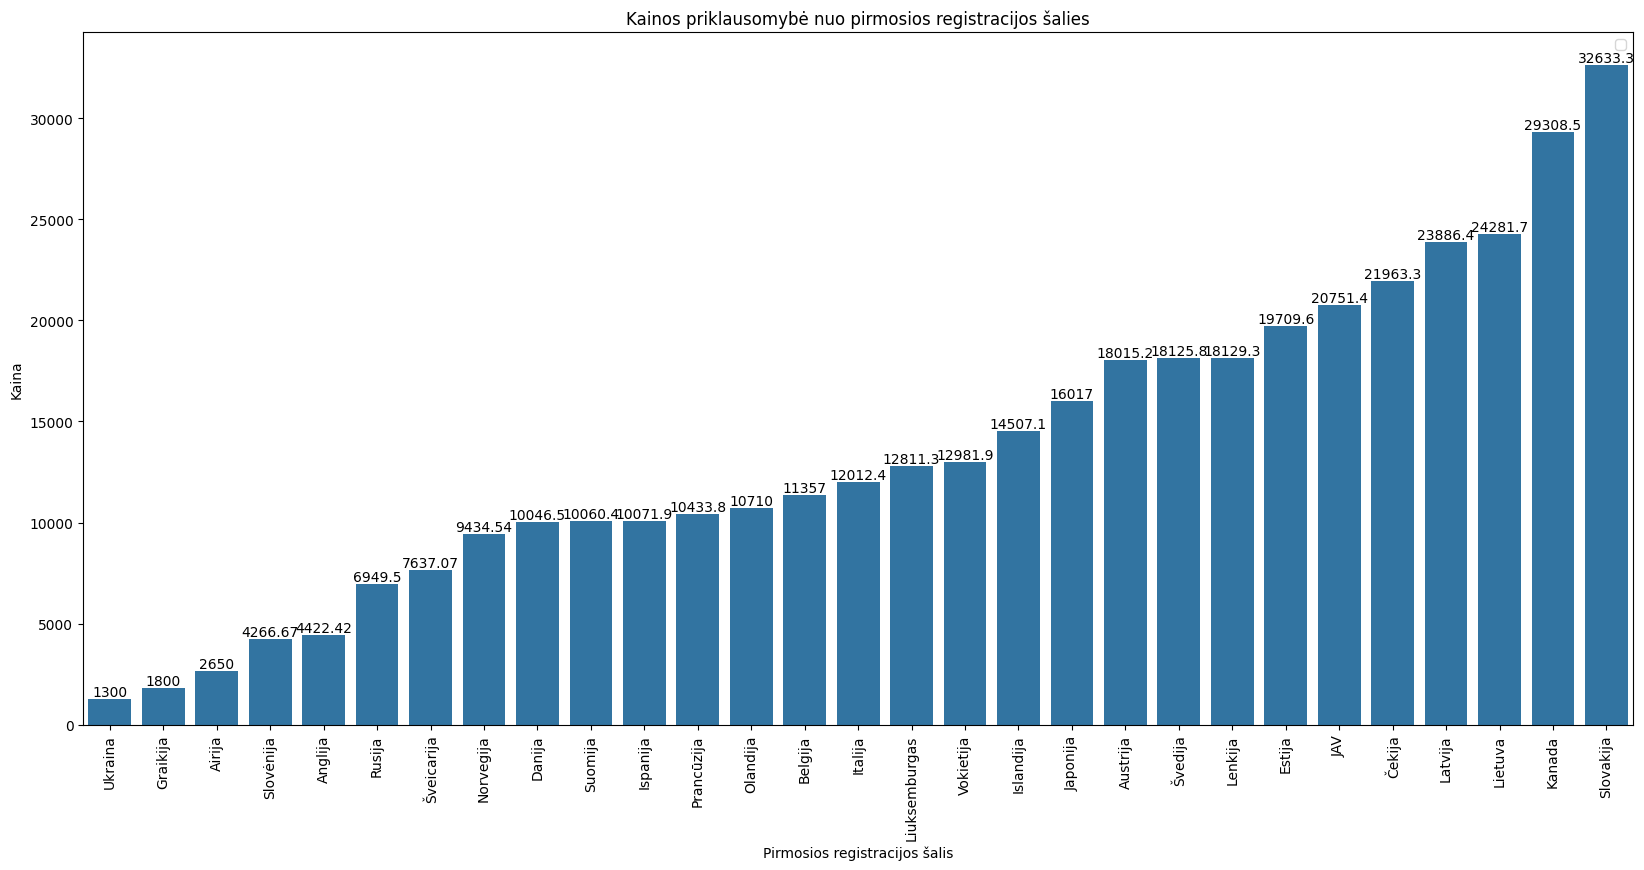

In [188]:

fig, axes = plt.subplots(figsize=(20,9))
dfx = dft[dft['Pirmosios registracijos šalis'] != np.nan].groupby(['Pirmosios registracijos šalis'])['Kaina'].mean().reset_index().sort_values(by= 'Kaina',ascending=True)
axes.set_title(f'Kainos priklausomybė nuo pirmosios registracijos šalies')
ax =sns.barplot(data=dfx,x = 'Pirmosios registracijos šalis', y='Kaina', )
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Pirmosios registracijos šalis',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

In [189]:
dft['TA'] = dft['Tech. apžiūra iki'].apply(lambda x: int(x[:4]) if x != None else None)

dft['Galioja_TA'] = dft['TA'].apply(lambda x: "Taip" if x>2024 else 'Ne')

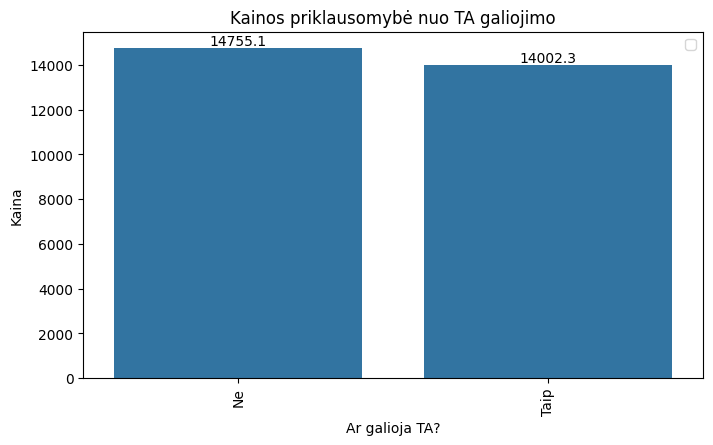

In [190]:
fig, axes = plt.subplots(figsize=(8,4.5))
dfx = dft.groupby(['Galioja_TA'])['Kaina'].mean().reset_index()
axes.set_title(f'Kainos priklausomybė nuo TA galiojimo')
ax =sns.barplot(data=dfx,x = 'Galioja_TA', y='Kaina', )
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Ar galioja TA?',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

In [191]:
dft['TA_m'] = dft['TA'].apply(lambda x: str(int(x)) if x>2024 else 'Negalioja')

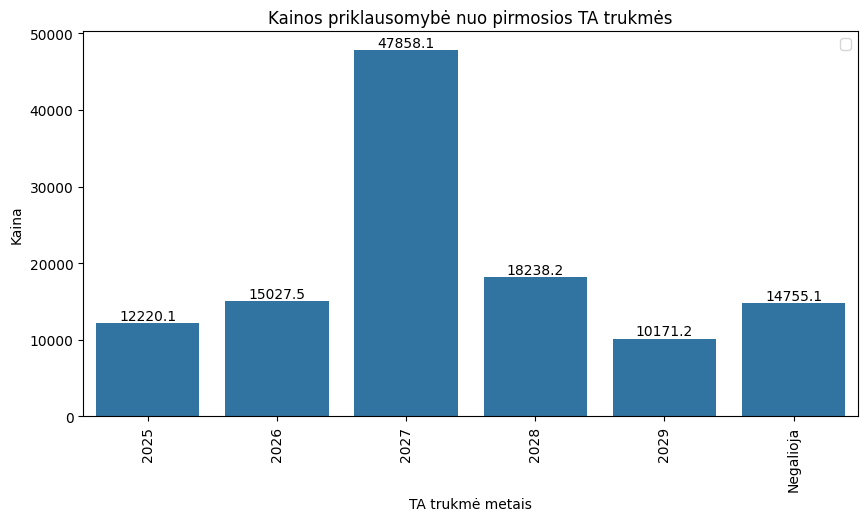

In [192]:
fig, axes = plt.subplots(figsize=(10,5))
dfx = dft[dft['TA_m'] != np.nan].groupby(['TA_m'])['Kaina'].mean().reset_index()
axes.set_title(f'Kainos priklausomybė nuo pirmosios TA trukmės')
ax =sns.barplot(data=dfx,x = 'TA_m', y='Kaina', )
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='TA trukmė metais',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

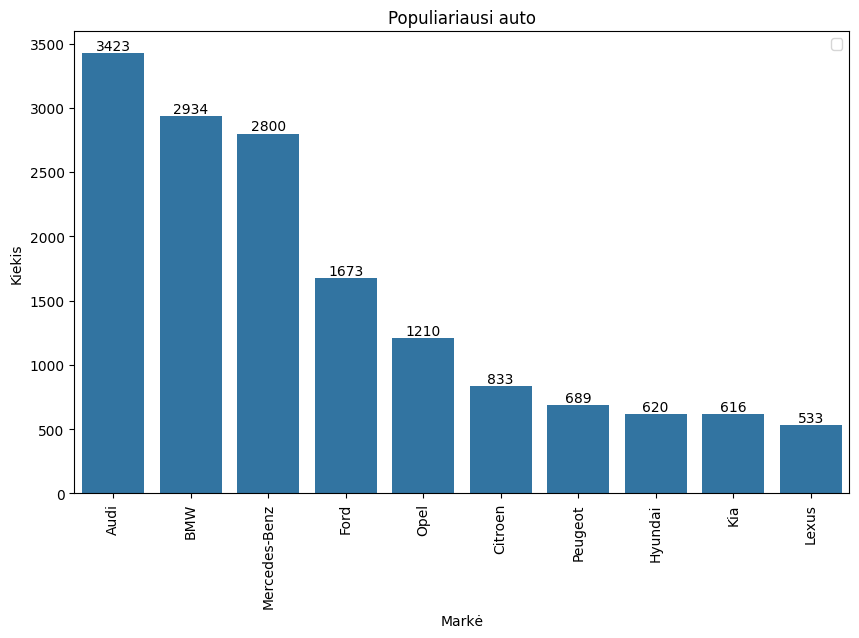

In [193]:
fig, axes = plt.subplots(figsize=(10,6))
dfx = dft[dft['Markė'] != np.nan].groupby(['Markė'])['Kaina'].count().reset_index().sort_values(by= 'Kaina',ascending=False)[:10]
axes.set_title(f'Populiariausi auto')
ax =sns.barplot(data=dfx,x = 'Markė', y='Kaina', )
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Markė',ylabel='Kiekis')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

In [194]:
pop_markes = list(set(list(dfx['Markė'])))
print(pop_markes)

['Peugeot', 'Lexus', 'Audi', 'Kia', 'Mercedes-Benz', 'Ford', 'BMW', 'Citroen', 'Opel', 'Hyundai']


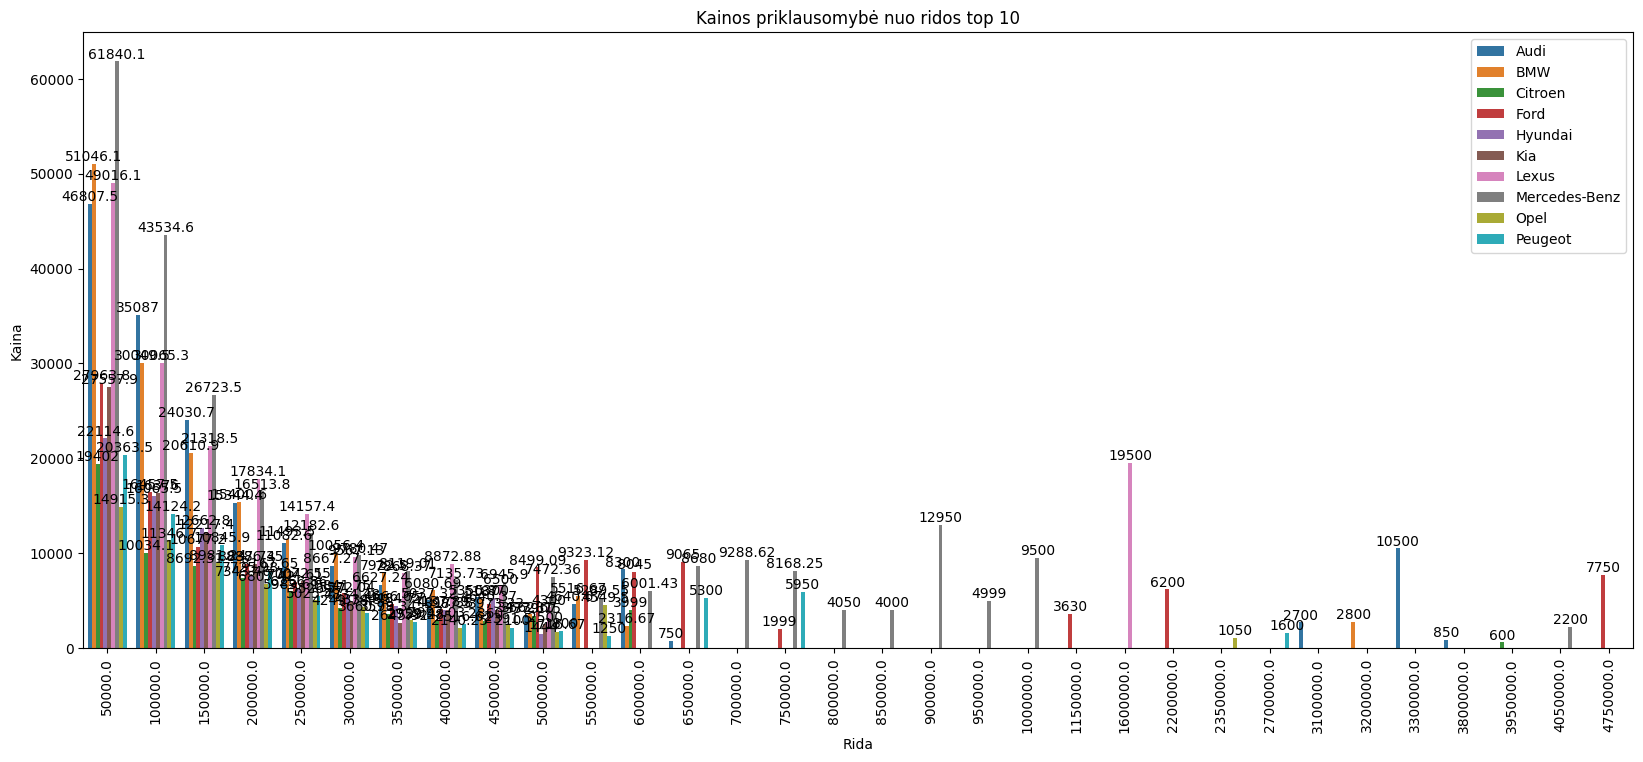

In [195]:
fig, axes = plt.subplots(figsize=(20,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dft[dft['Markė'].isin(pop_markes)].groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
axes.set_title(f'Kainos priklausomybė nuo ridos top 10')
ax =sns.barplot(data=dfx,x = 'Rida_group', y='Kaina', ax=axes, hue= 'Markė')
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Rida',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

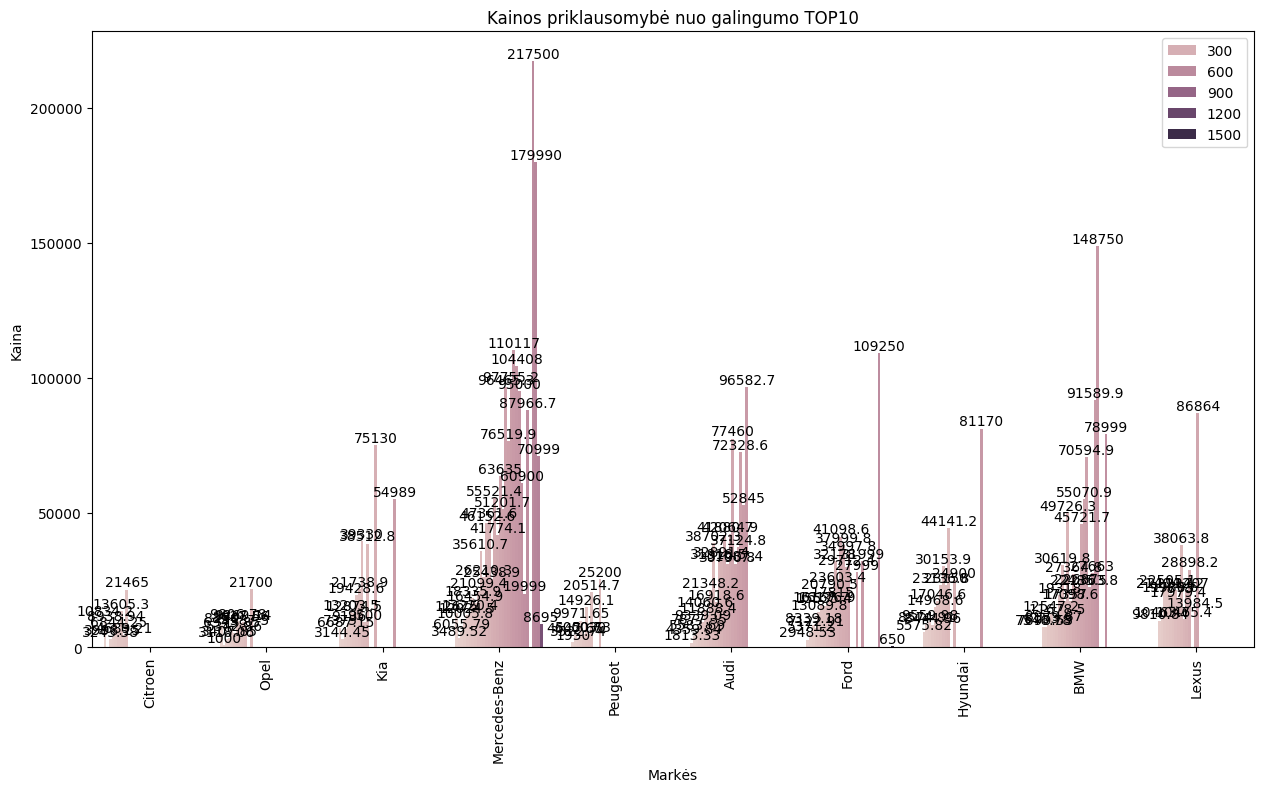

In [196]:
fig, axes = plt.subplots(figsize=(15,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dft[dft['Markė'].isin(pop_markes)].groupby(['Galingumas', 'Markė'])['Kaina'].mean().reset_index()
axes.set_title(f'Kainos priklausomybė nuo galingumo TOP10')
ax =sns.barplot(data=dfx,x = 'Markė', y='Kaina', ax=axes, hue= 'Galingumas')
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Markės',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

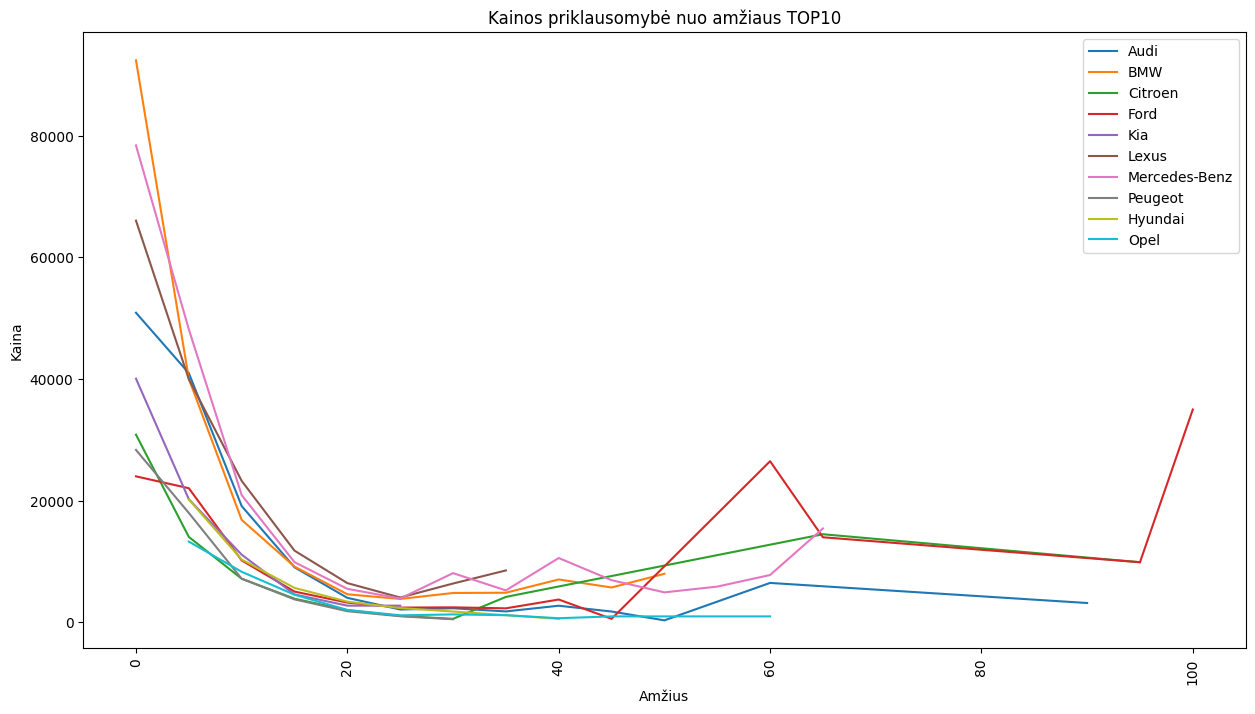

In [198]:
fig, axes = plt.subplots(figsize=(15,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dft[dft['Markė'].isin(pop_markes)].groupby(['Amžius', 'Markė'])['Kaina'].mean().reset_index()
dfx['Amžius'] = dfx['Amžius'].apply(lambda x: int(x))
axes.set_title(f'Kainos priklausomybė nuo amžiaus TOP10')
ax =sns.lineplot(data=dfx,x = 'Amžius', y='Kaina', ax=axes, hue= 'Markė')
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Amžius',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

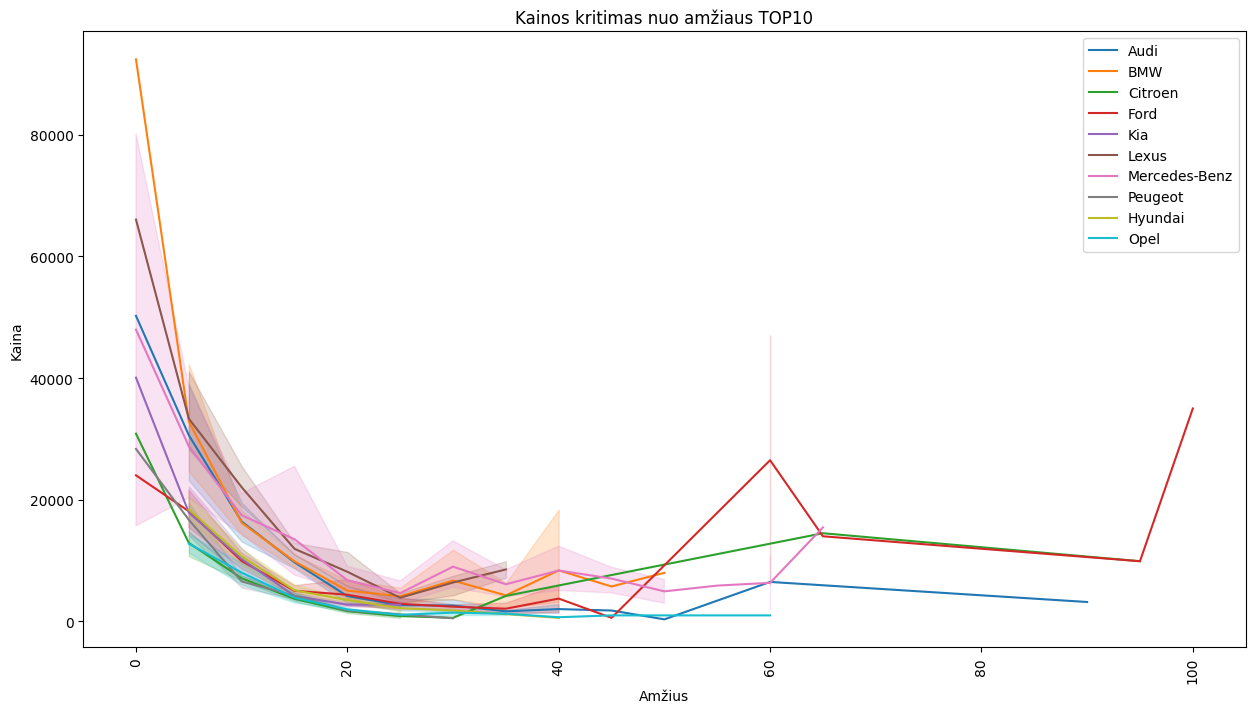

In [199]:
fig, axes = plt.subplots(figsize=(15,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dft[dft['Markė'].isin(pop_markes)].groupby(['Amžius', 'Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx['Amžius'] = dfx['Amžius'].apply(lambda x: int(x))
axes.set_title(f'Kainos kritimas nuo amžiaus TOP10')
ax =sns.lineplot(data=dfx,x = 'Amžius', y='Kaina', ax=axes, hue= 'Markė')
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Amžius',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

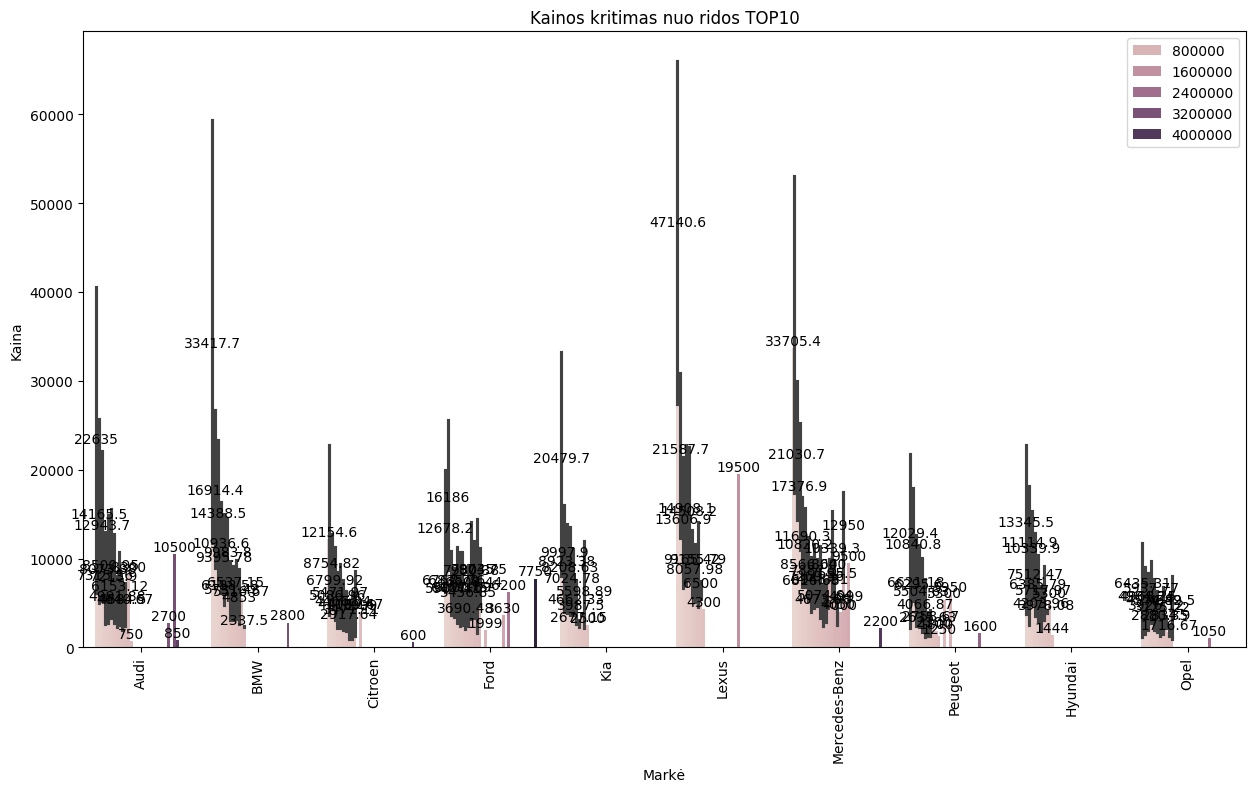

In [200]:
fig, axes = plt.subplots(figsize=(15,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dft[dft['Markė'].isin(pop_markes)].groupby(['Amžius', 'Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx['Amžius'] = dfx['Amžius'].apply(lambda x: int(x))
axes.set_title(f'Kainos kritimas nuo ridos TOP10')
ax =sns.barplot(data=dfx,x = 'Markė', y='Kaina', ax=axes, hue= 'Rida_group')
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Markė',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

In [210]:
dfx = dft[dft['Markė'] != np.nan].groupby(['Markė'])['Kaina'].count().reset_index().sort_values(by= 'Kaina',ascending=True)
dfx['Retas'] = dfx['Kaina'].apply(lambda x: True if x>5 and x<15 else False)
dfc = dfx[dfx['Retas'] == True].sort_values(by= 'Kaina',ascending=True)[:10]
ret_auto = list(set(list(dfc['Markė'])))
print(ret_auto)

['Alpina', 'Rolls-Royce', 'Hummer', 'GMC', 'Microcar', 'MG', 'Acura', 'DS Automobiles']


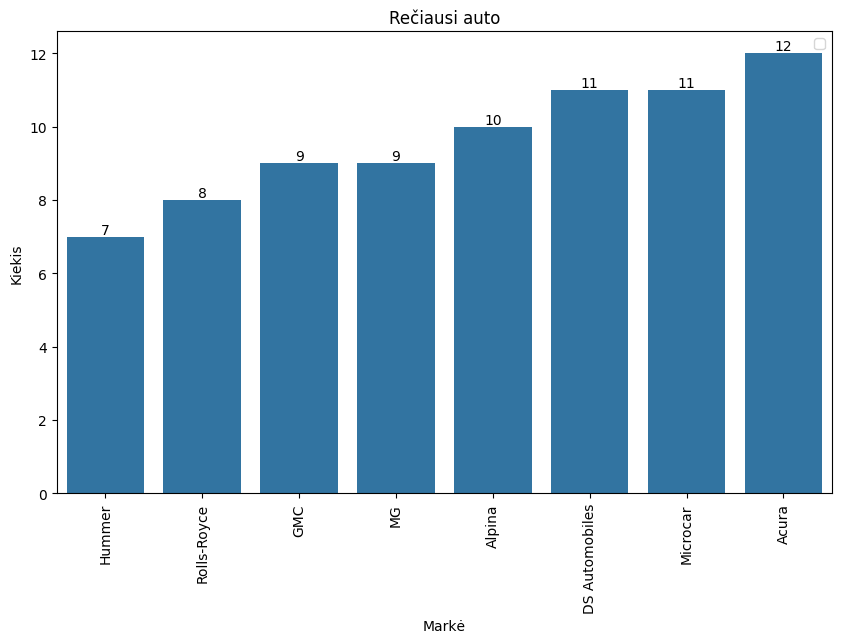

In [212]:

fig, axes = plt.subplots(figsize=(10,6))
dfx = dft[dft['Markė'].isin(ret_auto)].groupby(['Markė'])['Kaina'].count().reset_index().sort_values(by= 'Kaina', ascending=True)
axes.set_title(f'Rečiausi auto')
ax =sns.barplot(data=dfx,x = 'Markė', y='Kaina', )
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Markė',ylabel='Kiekis')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

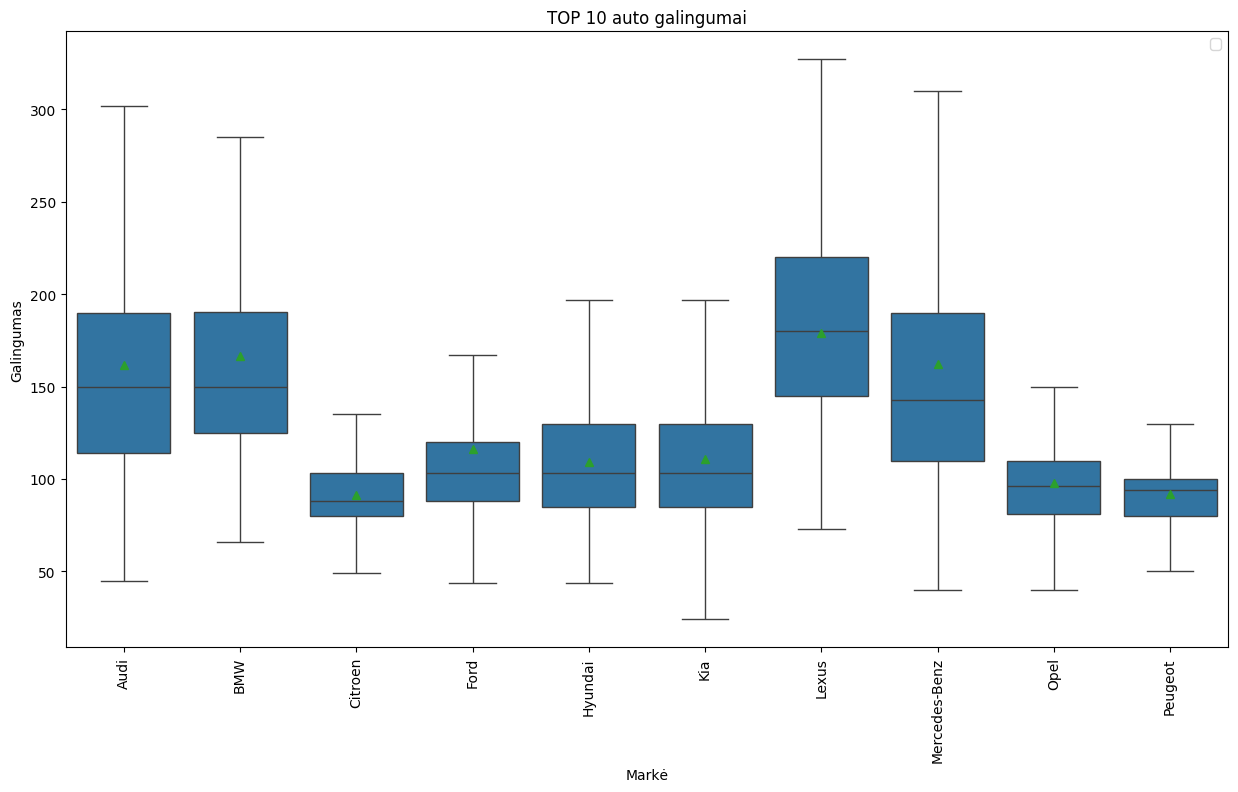

In [220]:
fig, axes = plt.subplots(figsize=(15,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dft[dft['Markė'].isin(pop_markes)]
axes.set_title(f'TOP 10 auto galingumai')
ax =sns.boxplot(data=dfx,x = 'Markė', y='Galingumas2', showmeans=True, showfliers=False)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Markė',ylabel='Galingumas')
# for container in ax.containers:
#     ax.bar_label(container)
axes.legend()
plt.show()

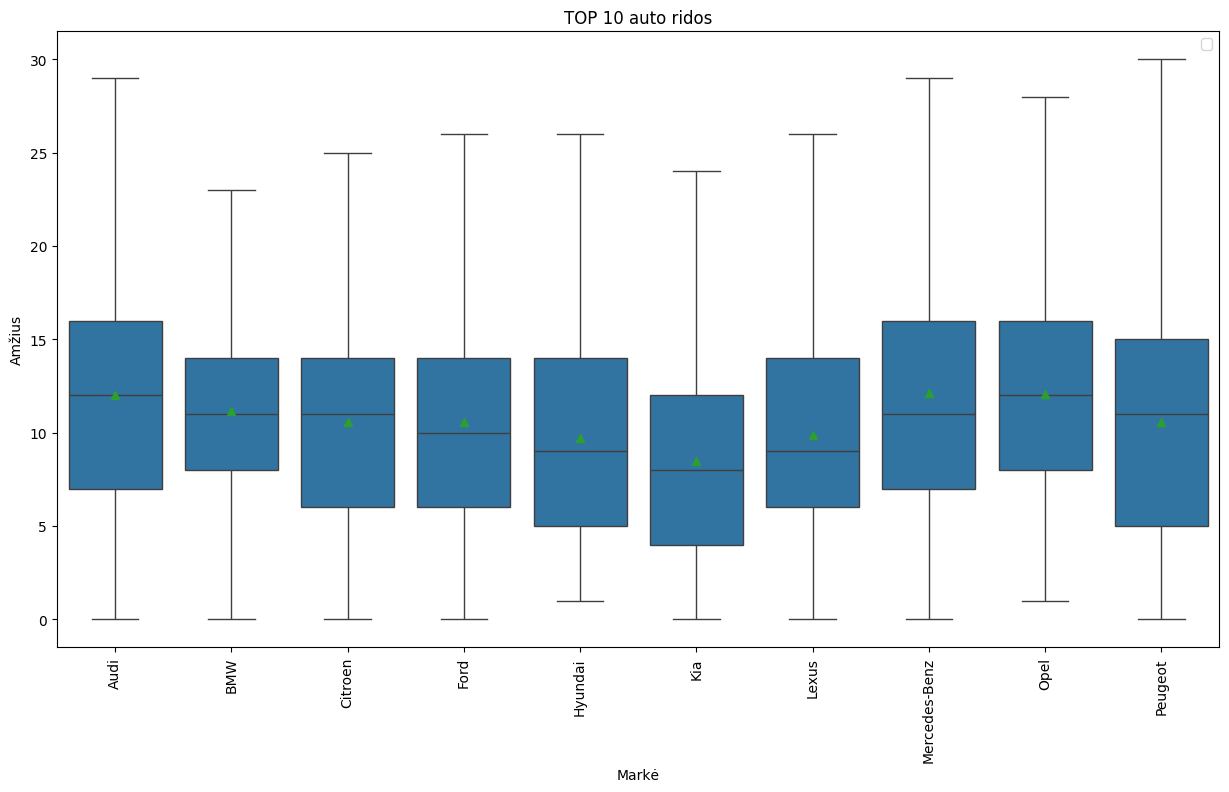

In [223]:
fig, axes = plt.subplots(figsize=(15,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dft[dft['Markė'].isin(pop_markes)]
axes.set_title(f'TOP 10 auto ridos')
ax =sns.boxplot(data=dfx,x = 'Markė', y='Amžius2', showmeans=True, showfliers=False)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Markė',ylabel='Amžius')
# for container in ax.containers:
#     ax.bar_label(container)
axes.legend()
plt.show()

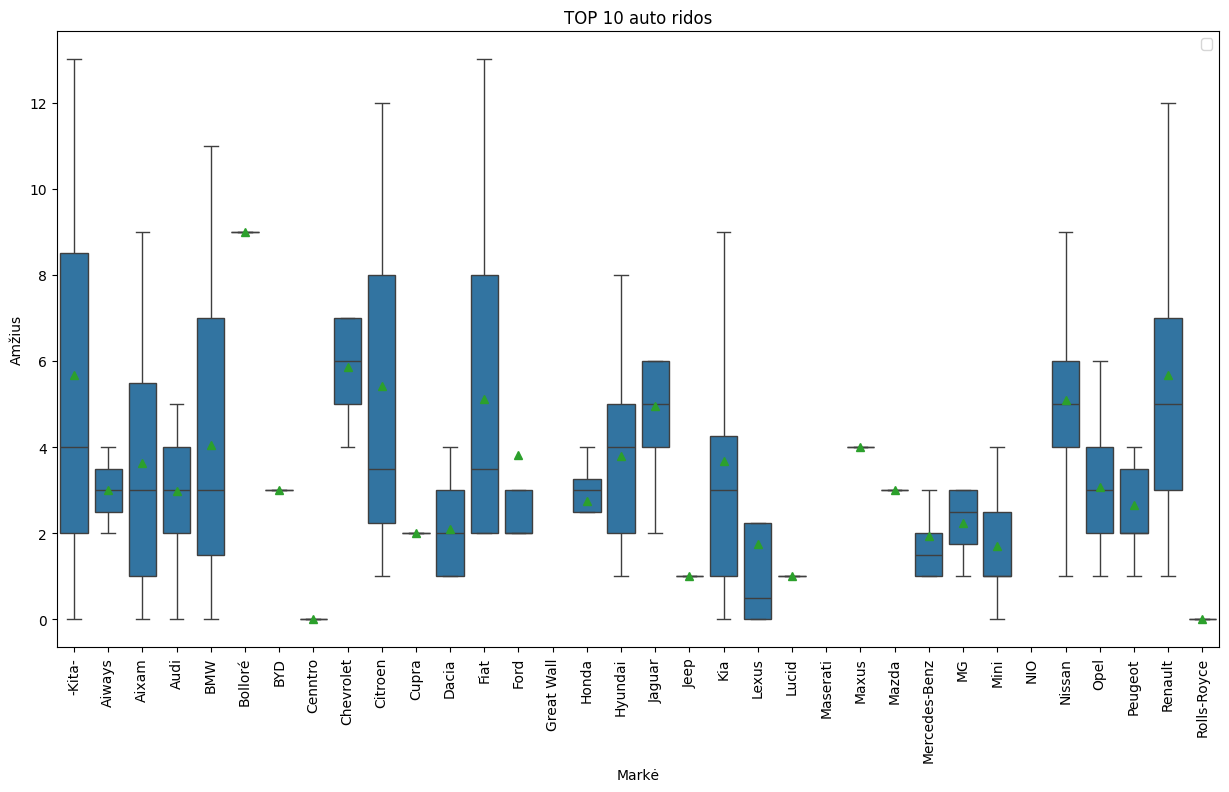

In [224]:
fig, axes = plt.subplots(figsize=(15,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dft[dft['Kuro tipas'] == 'Elektra']
axes.set_title(f'TOP 10 auto ridos')
ax =sns.boxplot(data=dfx,x = 'Markė', y='Amžius2', showmeans=True, showfliers=False)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Markė',ylabel='Amžius')
# for container in ax.containers:
#     ax.bar_label(container)
axes.legend()
plt.show()

In [234]:
dfe = dft[dft['Kuro tipas'] == 'Elektra']
dfe['Talpa'] = dfe['Baterijos talpa, kWh'].apply(lambda x: (np.ceil(int(x.replace(' kWh',''))/5))*5 if x!= None else None)

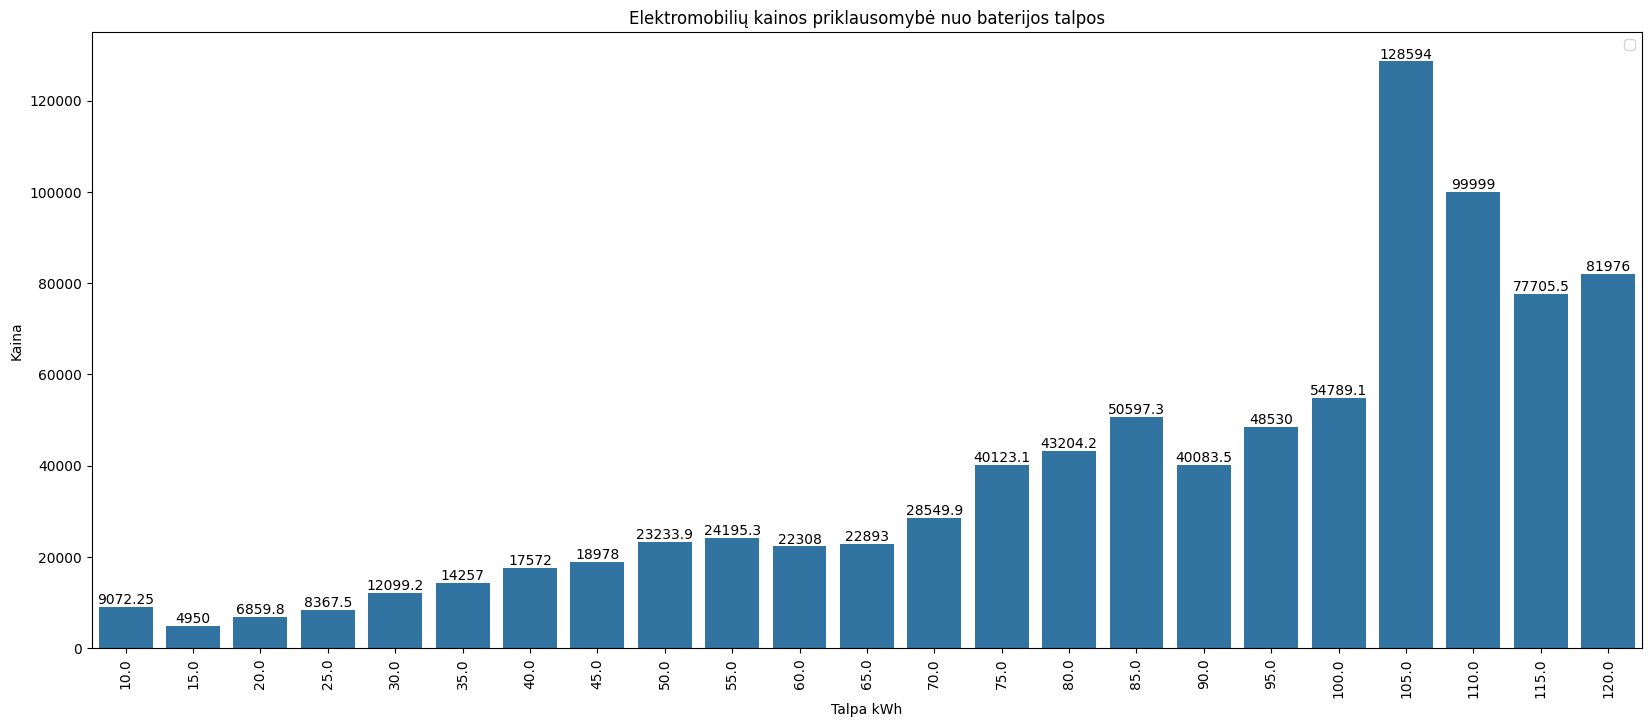

In [238]:
fig, axes = plt.subplots(figsize=(20,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dfe[dfe['Talpa'] != np.nan].groupby(['Talpa'])['Kaina'].mean().reset_index()
axes.set_title(f'Elektromobilių kainos priklausomybė nuo baterijos talpos')
ax =sns.barplot(data=dfx,x = 'Talpa', y='Kaina', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Talpa kWh',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

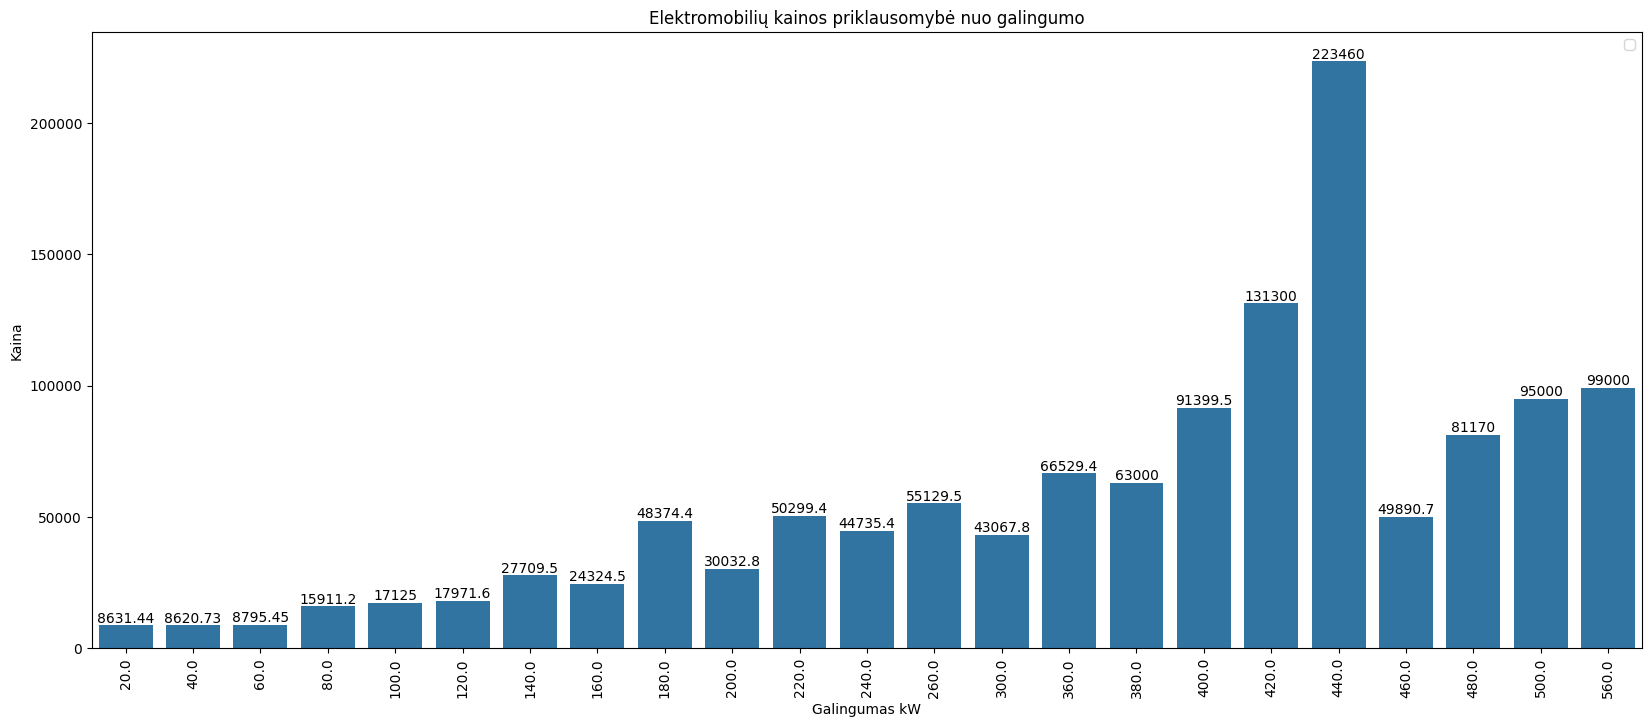

In [237]:
fig, axes = plt.subplots(figsize=(20,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dfe[dfe['Galingumas'] != np.nan].groupby(['Galingumas'])['Kaina'].mean().reset_index()
axes.set_title(f'Elektromobilių kainos priklausomybė nuo galingumo')
ax =sns.barplot(data=dfx,x = 'Galingumas', y='Kaina', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Galingumas kW',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

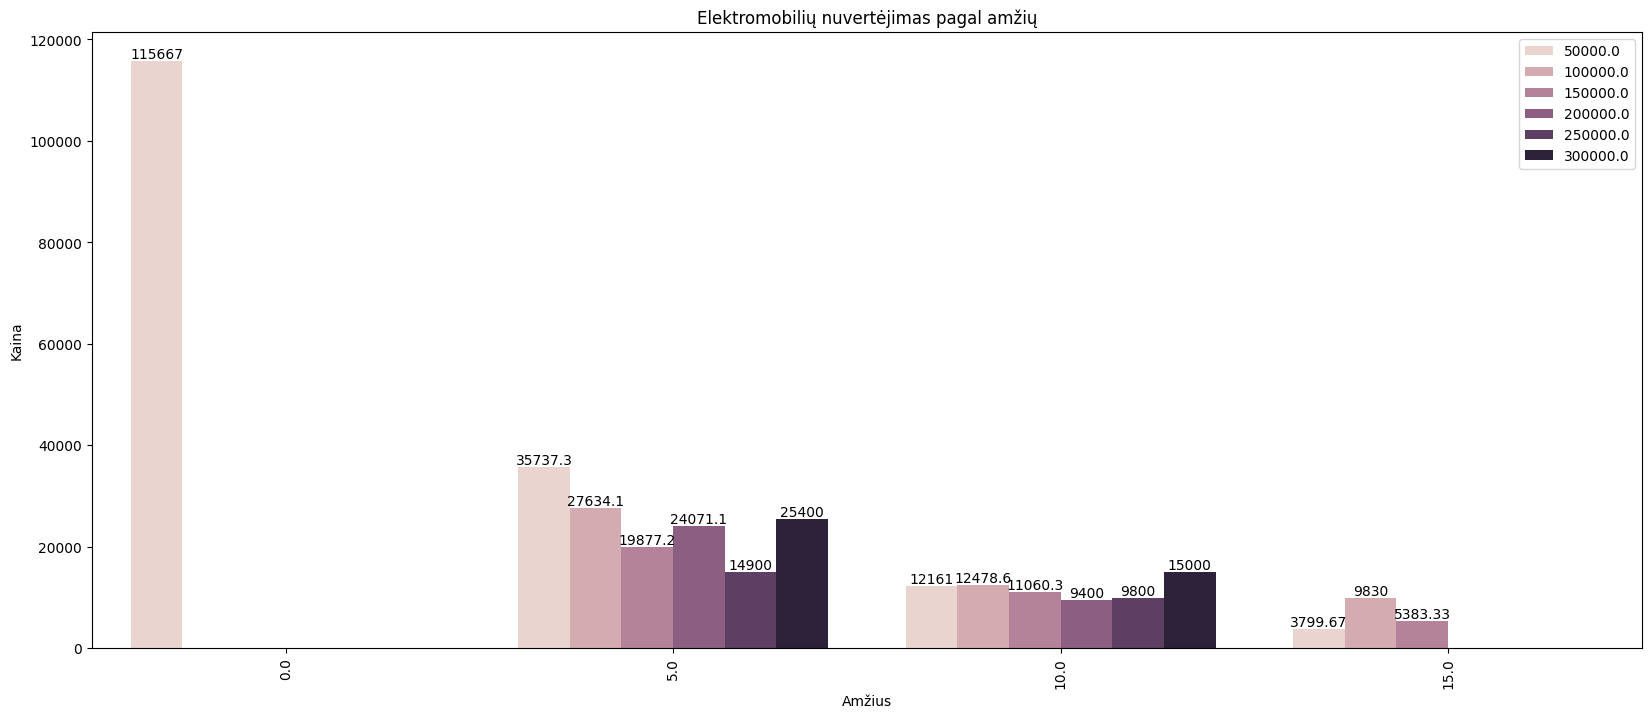

In [240]:
fig, axes = plt.subplots(figsize=(20,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dfe[dfe['Amžius'] != np.nan].groupby(['Amžius', 'Rida_group'])['Kaina'].mean().reset_index()
axes.set_title(f'Elektromobilių nuvertėjimas pagal amžių')
ax =sns.barplot(data=dfx,x = 'Amžius', y='Kaina', ax=axes, hue='Rida_group')
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Amžius',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

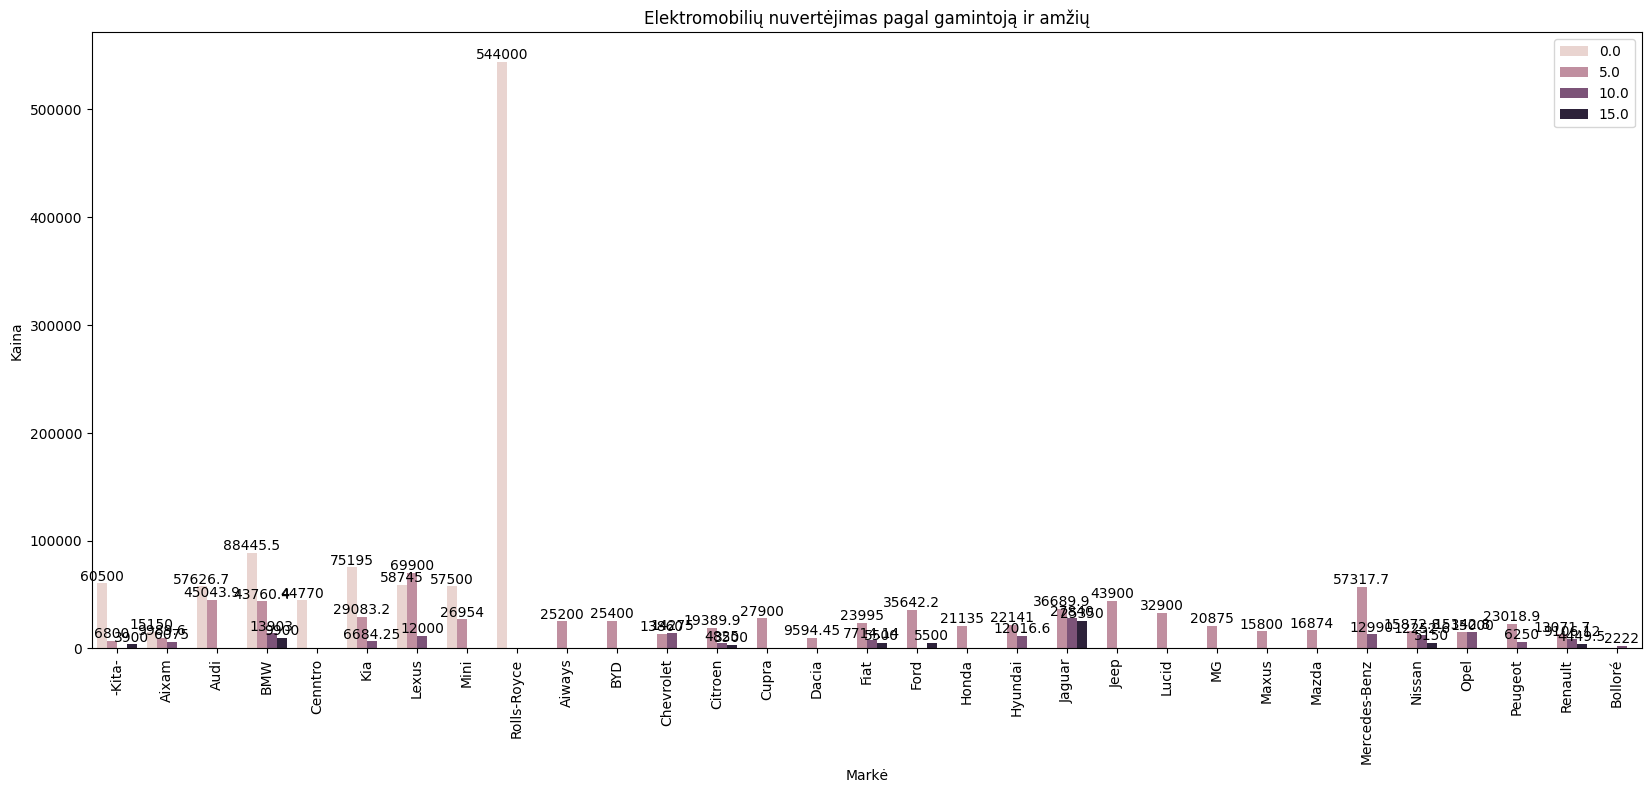

In [241]:
fig, axes = plt.subplots(figsize=(20,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dfe[dfe['Amžius'] != np.nan].groupby(['Amžius', 'Markė'])['Kaina'].mean().reset_index()
axes.set_title(f'Elektromobilių nuvertėjimas pagal gamintoją ir amžių')
ax =sns.barplot(data=dfx,x = 'Markė', y='Kaina', ax=axes, hue='Amžius')
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Markė',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()

In [244]:
dft['El'] = dft['Kuro tipas'].apply(lambda x: "Elektra" if x == 'Elektra' else "VDV")

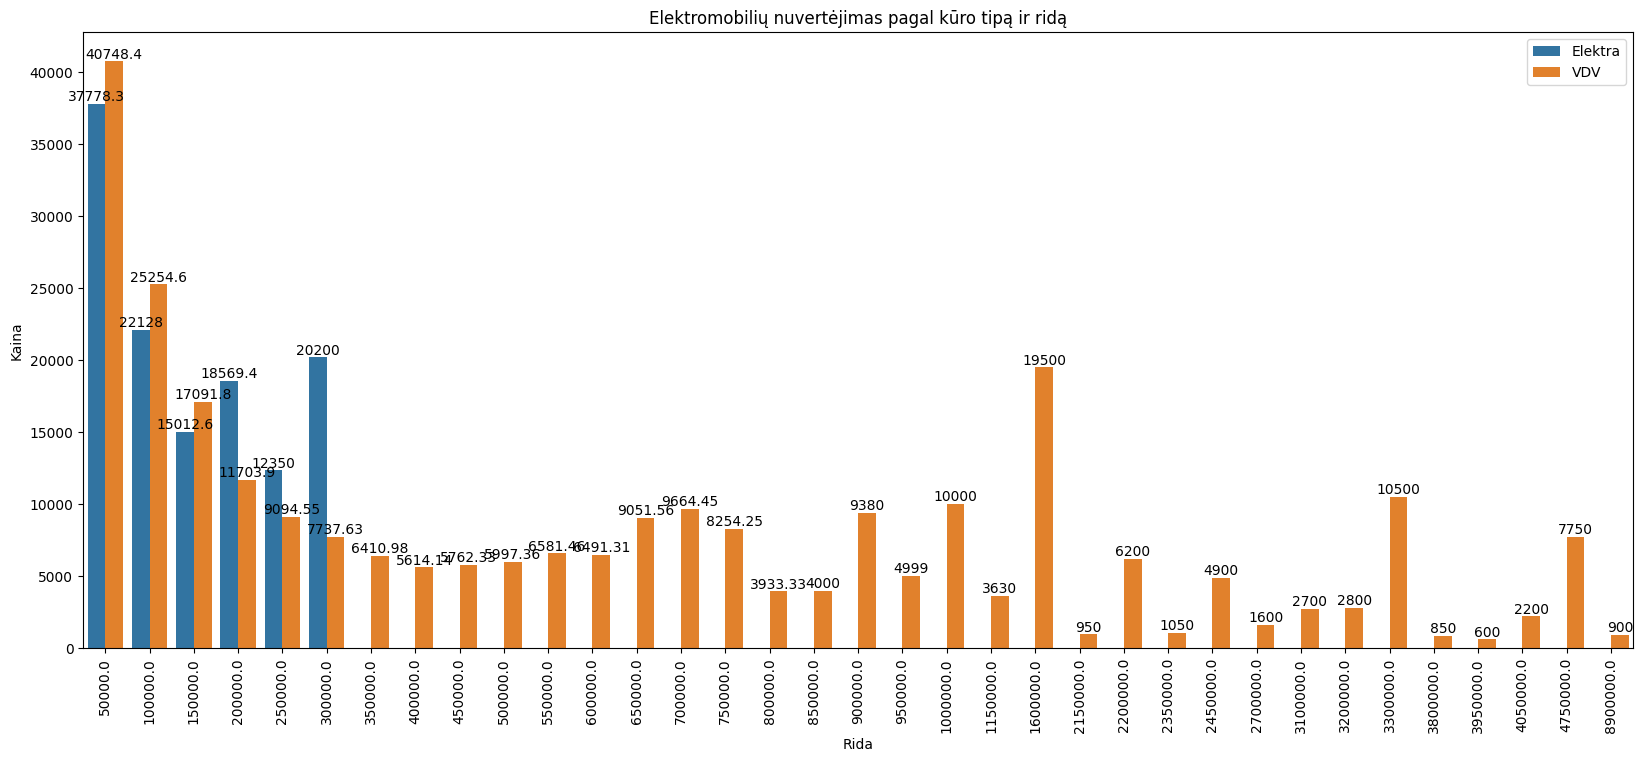

In [245]:
fig, axes = plt.subplots(figsize=(20,8))
# dfx = dft.query('Markė in @pop_markes').groupby(['Rida_group', 'Markė'])['Kaina'].mean().reset_index()
dfx = dft.groupby(['El', 'Rida_group'])['Kaina'].mean().reset_index()
axes.set_title(f'Elektromobilių nuvertėjimas pagal kūro tipą ir ridą')
ax =sns.barplot(data=dfx,x = 'Rida_group', y='Kaina', ax=axes, hue='El')
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set(xlabel='Rida',ylabel='Kaina')
for container in ax.containers:
    ax.bar_label(container)
axes.legend()
plt.show()